# Project 3: Panoramic Mosaicing

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">About 40 minutes</span>
* 2. Part B: <span style="color:red;">About 30 minutes</span>
* 3. Part C: <span style="color:red;">About 12 hours</span>
* 4. Part D: <span style="color:red;">About 2 hours</span>
* 5. Write-up: <span style="color:red;">About 15 minutes</span>

### Programming Exercise

For this assignment, you will be writing a program that creates a panoramic mosaic from 2 or more images.  In general this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of up to 90 or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected (either manually or by your program) to be the base photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In describing what you need to do, there will be a running example using the three photos below:


<div style="width:100%;text-align:center;"><img src="Images/example1.png" width=100%></div>
        

### Part A: Find Interest Points/Descriptors in each Input Image
We will be using OpenCV for this project, which you should already have installed.  However, you may need to install the contrib version--which comes seperate due to the SIFT algorithm being patented--by running the command:`pip install opencv-contrib-python`.  A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

See the red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.

<div style="width:100%;text-align:center;"><img src="Images/example2.png" width=100%></div>

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional.  You want to find putative pairs--pairs of points which are each other’s best match (e.g. there might be 3 points in image I1 for which a point q in image I2 are the best match, only one of these could be the best matching point p in I1 for that point q in I2).  In this part you need to compute the set of putative matches between each pair of images.

Look at the pairs of images and the lines showing the estimated matches (putative matches are green lines, one way matches are cyan or blue).

<div style="width:100%;text-align:center;"><img src="Images/example3.png" width=100%></div>

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4), estimate the homography between each pair of images.  You will need to decide whether you’re going to manually specify the base image or determine in programmatically.  Along with identifying the base image, you need to figure out the order in which you will composite the other images to the base.

You will need 4 pairs of points to estimate a homography.  Begin by randomly sampling sets of 4 pairs and estimating the corresponding homography for each set.  Instead of the two warping equations that we used earlier in the semester, it is recommended that you use a 3x3 homography (8 unknowns).  You are trying to estimate the homography

$$
\begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}
$$

such that a point $(x_s,y_s)$ in the source image is tranformed to a point $(x_t,y_t)$ in the target image as follows

$$
\begin{bmatrix}x_t\\y_t\\1\end{bmatrix} = \begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}\begin{bmatrix}x_s\\y_s\\1\end{bmatrix}
$$

Each pair of points will produce three linear equations in (a subset of) the 8 unknowns.  For example, $x_t = x_sa + y_sb + c$.  Four pairs of points (assuming no degeneracies) are sufficient to estimate the homography.  A more robust solution relying on more than four pairs can be obtained using least squares on the overconstrained linear system (solving $Ax = b$, where $x$ is a column vector with the 8 unknowns and you populate rows of $A$ and an entry of $b$ with the linear equations just described).  Note that this solution will **not** always be better.

Because of the homogeneous coordinates, the three equations can be reduced to two equations as follows:

$$
x_t = \frac{ax_s+by_s+c}{gx_s+hy_s+1}, \hspace{5mm}
y_t = \frac{dx_s+ey_s+f}{gx_s+hy_s+1}
$$

For more details, see the [image alignment and stitching slides](https://faculty.cs.byu.edu/~farrell/courses/CS450/slides/alignment_stitching.pdf#page=18).

Below you will find a visualization of the RANSAC estimated homographies.  Images 1, 2, and 3 have dots that are red, green and blue respectively (sorry the dots are a little small), representing the putative pairs.  You can see where the homographies line up very well and in a few places (the middle vertically) they line up slightly less well.

<div style="width:100%;text-align:center;"><img src="Images/example4.png" width=100%></div>

### Part D: Creating the Mosaic

Begin with the base image and warp the remaining images (using the estimated homographies) to composite them onto the base image.

For the ongoing campus example, here are the resulting warped images composited.

<div style="width:100%;text-align:center;"><img src="Images/example5.png" width=75%></div>

And, then with a very simple (but not ideal) compositing operation.

<div style="width:100%;text-align:center;"><img src="Images/example6.png" width=75%></div>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

import cv2

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': plt.rcParams['axes.titlesize'],
                                 'fontweight' : plt.rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

### Part A: Find Interest Points/Descriptors

In [3]:
# Place Code Here
# Show an example output here
def find_kp_and_des(images: List, return_example_images: bool = False) -> Tuple:
    keypoints, descriptors, example_images = [], [], []

    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        sift = cv2.SIFT_create()

        img_keypoints, img_descriptors = sift.detectAndCompute(img_gray, None)

        keypoints.append(img_keypoints)
        descriptors.append(img_descriptors)

        if return_example_images:
            display_img = img.copy()
            circle_color = (0, 255, 255)

            keypoints_sample = np.random.choice(img_keypoints, size=1000, replace=False)

            for kp in keypoints_sample:
                x, y = kp.pt

                x = int(x)
                y = int(y)

                radius = int(kp.size * 10)

                display_img = cv2.circle(display_img, (x, y), radius, circle_color, 10)

            example_images.append(display_img)

    return (keypoints, descriptors, example_images) if return_example_images else (keypoints, descriptors)

In [4]:
img1 = cv2.imread('./Images/campus1.jpg')
img2 = cv2.imread('./Images/campus3.jpg')
img3 = cv2.imread('./Images/campus2.jpg')

images = [img1, img2, img3]

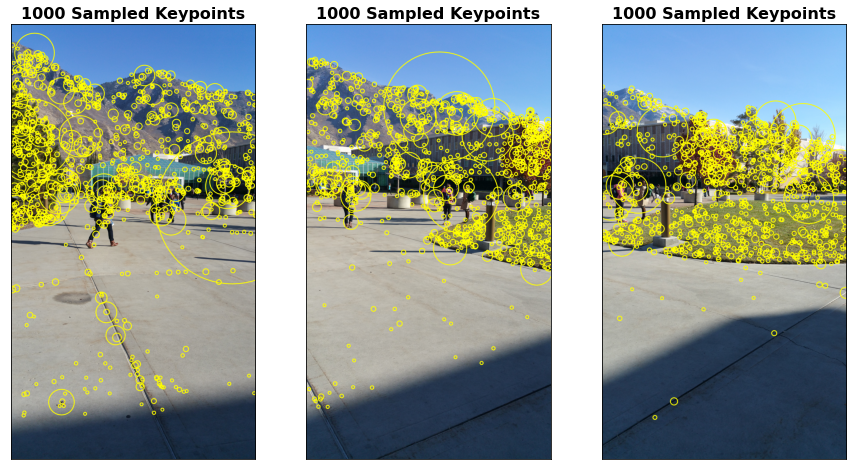

In [5]:
keypoints, descriptors, example_images = find_kp_and_des(images, True)

# Can calculate for an arbitrary amount of images but display/plotting is limited to 3 for simplicity
subplot_num = 131
example_image_cutoff = 3 if len(example_images) > 3 else len(example_images)

for img in example_images[:example_image_cutoff]:
    plt.subplot(subplot_num)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    just_title('1000 Sampled Keypoints')

    subplot_num += 1

### Part B: Matching Features

In [6]:
# Place Code Here
# Show an example output here
def find_matches(images: List, descriptors: List, keypoints: List, return_example_images: bool = False) -> Tuple:
    assert len(images) == len(descriptors) and len(descriptors) == len(keypoints)

    matcher = cv2.BFMatcher(crossCheck=True)

    matches, example_images = [], []

    for i in range(len(descriptors)):
        for j in range(i + 1, len(descriptors)):
            curr_matches = matcher.match(descriptors[i], descriptors[j])

            matches.append((i, j, curr_matches))

            if return_example_images:
                matches_cutoff = 1000 if len(curr_matches) > 1000 else len(curr_matches)
                example_images.append(cv2.drawMatches(images[i], keypoints[i], images[j], keypoints[j], curr_matches[:matches_cutoff], None))

    return (matches, example_images) if return_example_images else (matches)

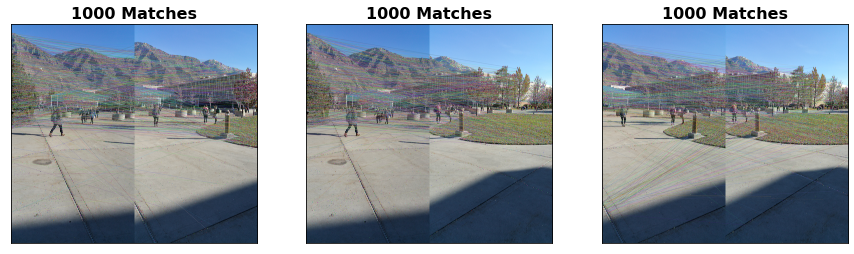

In [7]:
matches, example_matches = find_matches(images, descriptors, keypoints, True)

# Can calculate for an arbitrary amount of images but display/plotting is limited to 3 for simplicity
subplot_num = 131
example_match_cutoff = 3 if len(example_matches) > 3 else len(example_matches)

for img in example_matches[:example_match_cutoff]:
    plt.subplot(subplot_num)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    just_title('1000 Matches')

    subplot_num += 1

### Part C: Estimating Pairwise Homographies using RANSAC

In [9]:
# Place Code Here
# Show an example output here
def ransac_homographies(keypoints: List, matches: List, base_img_idx: int, ransac_n_iterations=1000, epsilon=10):
    homographies = []

    for i, j, matching_points in matches:
        if i != base_img_idx and j != base_img_idx:
            continue

        source_kps, dest_kps = (keypoints[i], keypoints[j]) if i != base_img_idx else (keypoints[j], keypoints[i])

        best_homography = None
        best_consensus_size = -np.inf

        for _ in range(ransac_n_iterations):
            success = False

            while not success:
                random_indices = np.random.choice(range(len(matching_points)), size=4, replace=False)

                source_pairs = []
                dest_pairs = []

                for idx in random_indices:
                    query_idx, train_idx = matching_points[idx].queryIdx, matching_points[idx].trainIdx
                    source_idx, dest_idx = (query_idx, train_idx) if i != base_img_idx else (train_idx, query_idx)

                    x_s, y_s  = source_kps[source_idx].pt
                    x_d, y_d  = dest_kps[dest_idx].pt

                    source_pairs.append((x_s, y_s))
                    dest_pairs.append((x_d, y_d))

                assert len(source_pairs) == len(dest_pairs) == 4

                A = []
                b = []

                for k in range(len(source_pairs)):
                    x_s, y_s, x_d, y_d = source_pairs[k][0], source_pairs[k][1], dest_pairs[k][0], dest_pairs[k][1]
                    A.append([x_s, y_s, 1, 0, 0, 0, -x_d * x_s, -x_d * y_s])
                    A.append([0, 0, 0, x_s, y_s, 1, -y_d * x_s, -y_d * y_s])
                    b.extend([x_d, y_d])

                A = np.array(A).reshape(8, 8)
                b = np.array(b).reshape(-1, 1)

                try:
                    homography = np.linalg.solve(A, b)

                except:
                    continue

                success = True
                
                homography = list(homography.reshape(1, -1)[0])
                homography.append(1)
                homography = np.array(homography).reshape(1, -1)
                curr_consensus_size = 0

                for k in range(len(source_pairs)):
                    x_s, y_s, x_d, y_d = source_pairs[k][0], source_pairs[k][1], dest_pairs[k][0], dest_pairs[k][1]

                    # Use the equation from the class slides - only way I could figure out how to get it to work
                    x_hat = ((homography[0][0] * x_s) + (homography[0][1] * y_s) + homography[0][2]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1)
                    y_hat = ((homography[0][3] * x_s) + (homography[0][4] * y_s) + homography[0][5]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1)
                    pred_dest_vec = np.array([x_hat, y_hat]).reshape(-1, 1)
                    dest_vec = np.array([x_d, y_d]).reshape(-1, 1)
                    dist = np.linalg.norm(pred_dest_vec - dest_vec)

                    if round(dist) != 0:
                        success = False
                        break

                if not success:
                    continue

                for k in range(len(matching_points)):
                    query_idx, train_idx = matching_points[k].queryIdx, matching_points[k].trainIdx
                    source_idx, dest_idx = (query_idx, train_idx) if i != base_img_idx else (train_idx, query_idx)

                    x_s, y_s  = np.round(source_kps[source_idx].pt)
                    x_d, y_d  = np.round(dest_kps[dest_idx].pt)

                    x_hat = ((homography[0][0] * x_s) + (homography[0][1] * y_s) + homography[0][2]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1)
                    y_hat = ((homography[0][3] * x_s) + (homography[0][4] * y_s) + homography[0][5]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1)
                    pred_dest_vec = np.array([x_hat, y_hat]).reshape(-1, 1)
                    dest_vec = np.array([x_d, y_d]).reshape(-1, 1)
                    dist = np.linalg.norm(pred_dest_vec - dest_vec)

                    curr_consensus_size += 1 if dist <= epsilon else 0

                if curr_consensus_size > best_consensus_size:
                    best_consensus_size = curr_consensus_size
                    best_homography = homography  

        homographies.append((i, j, best_homography))

    return homographies

In [10]:
base_img_idx = 1

homographies = ransac_homographies(keypoints, matches, base_img_idx=base_img_idx)

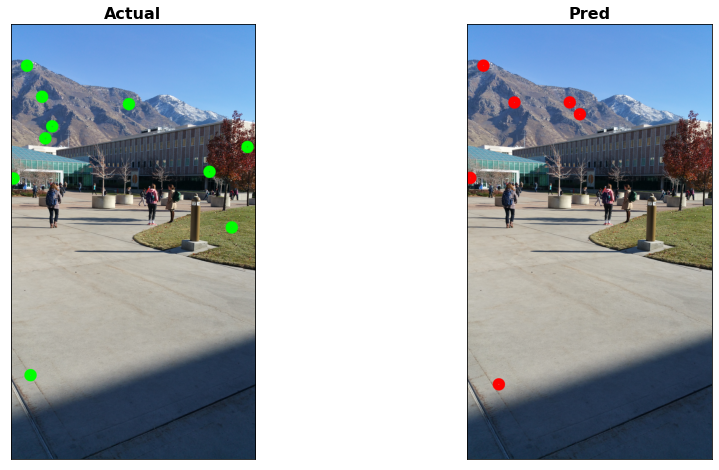

In [51]:
# Shows a few points (10) on the base image and what the homography predicts - sometimes
# the homography predicts points at negative coordinates, so those will not appear in the 
# display
subplot_num = 121

homography_idx = 0

i, j, homography = homographies[homography_idx]

matching_points = None

for i_m, j_m, m_points in matches:
    if i == i_m and j == j_m:
        matching_points = m_points
        break

assert matching_points is not None

image1, image2 = images[i], images[j]

dest_img = image1 if i == base_img_idx else image2
output_img_actual = dest_img.copy()
output_img_pred = dest_img.copy()
source_kps, dest_kps = (keypoints[i], keypoints[j]) if i != base_img_idx else (keypoints[j], keypoints[i])

random_indices = np.random.choice(range(len(matching_points)), size=10, replace=False)

source_pairs = []
dest_pairs = []

for idx in random_indices:
    query_idx, train_idx = matching_points[idx].queryIdx, matching_points[idx].trainIdx
    source_idx, dest_idx = (query_idx, train_idx) if i != base_img_idx else (train_idx, query_idx)

    x_s, y_s  = source_kps[source_idx].pt
    x_d, y_d  = np.round(dest_kps[dest_idx].pt)

    source_pairs.append((x_s, y_s))
    dest_pairs.append((x_d, y_d))

assert len(source_pairs) == len(dest_pairs) == 10

actual_circle_color = (0, 255, 0)
pred_circle_color = (0, 0, 255)

for k in range(len(source_pairs)):
    x_s, y_s = source_pairs[k]
    x_d, y_d = dest_pairs[k]

    x_hat = ((homography[0][0] * x_s) + (homography[0][1] * y_s) + homography[0][2]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1)
    y_hat = ((homography[0][3] * x_s) + (homography[0][4] * y_s) + homography[0][5]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1)

    pred_dest_vec = np.round(np.array([x_hat, y_hat]).reshape(1, -1))

    output_img_actual = cv2.circle(output_img_actual, (int(x_d), int(y_d)), 40, actual_circle_color, 70)
    output_img_pred = cv2.circle(output_img_pred, (int(pred_dest_vec[0][0]), int(pred_dest_vec[0][1])), 40, pred_circle_color, 70)

plt.subplot(subplot_num)
plt.imshow(cv2.cvtColor(output_img_actual, cv2.COLOR_BGR2RGB))
just_title('Actual')

subplot_num += 1

plt.subplot(subplot_num)
plt.imshow(cv2.cvtColor(output_img_pred, cv2.COLOR_BGR2RGB))
just_title('Pred')

### Part D: Creating the Mosaic

In [11]:
def median_filter(image, width=3, height=3):    
    return cv2.medianBlur(image, width, height)

In [12]:
# I'm sure there's a much faster way to do this using cv2 functions, but I couldn't quite get them to work
# and have already spent WAY too much time on this lab
def stitch_images(images: List, homographies: List, base_img_idx: int):
    x_min, x_max = np.inf, -np.inf
    y_min, y_max = np.inf, -np.inf

    for i, j, homography in homographies:
        src_image = images[i] if i != base_img_idx else images[j]

        h, w = src_image.shape[:-1]

        # Top-left corner
        x_s, y_s = 0, 0

        x_hat = round(((homography[0][0] * x_s) + (homography[0][1] * y_s) + homography[0][2]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))
        y_hat = round(((homography[0][3] * x_s) + (homography[0][4] * y_s) + homography[0][5]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))

        x_min, x_max = int(min([x_min, x_hat])), int(max([x_max, x_hat]))
        y_min, y_max = int(min([y_min, y_hat])), int(max([y_max, y_hat]))

        # Top-right corner
        x_s, y_s = w - 1, 0

        x_hat = round(((homography[0][0] * x_s) + (homography[0][1] * y_s) + homography[0][2]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))
        y_hat = round(((homography[0][3] * x_s) + (homography[0][4] * y_s) + homography[0][5]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))

        x_min, x_max = int(min([x_min, x_hat])), int(max([x_max, x_hat]))
        y_min, y_max = int(min([y_min, y_hat])), int(max([y_max, y_hat]))

        # Bottom-left corner
        x_s, y_s = 0, h - 1

        x_hat = round(((homography[0][0] * x_s) + (homography[0][1] * y_s) + homography[0][2]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))
        y_hat = round(((homography[0][3] * x_s) + (homography[0][4] * y_s) + homography[0][5]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))

        x_min, x_max = int(min([x_min, x_hat])), int(max([x_max, x_hat]))
        y_min, y_max = int(min([y_min, y_hat])), int(max([y_max, y_hat]))

        # Bottom-right corner
        x_s, y_s = w - 1, h - 1

        x_hat = round(((homography[0][0] * x_s) + (homography[0][1] * y_s) + homography[0][2]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))
        y_hat = round(((homography[0][3] * x_s) + (homography[0][4] * y_s) + homography[0][5]) / ((homography[0][6] * x_s) + (homography[0][7] * y_s) + 1))

        x_min, x_max = int(min([x_min, x_hat])), int(max([x_max, x_hat]))
        y_min, y_max = int(min([y_min, y_hat])), int(max([y_max, y_hat]))

    final_width, final_height = x_max - x_min + 1, y_max - y_min + 1
    dx, dy = abs(x_min) - 1, abs(y_min) - 1

    translation_matrix = np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]]).reshape(3, 3)

    final_image = np.full((final_height, final_width, 3), 0)

    base_image = images[base_img_idx]
    base_img_h, base_img_w = base_image.shape[:-1]

    for x in range(base_img_w):
        for y in range(base_img_h):
            translated_coordinates = translation_matrix.dot(np.array([x, y, 1]).reshape(-1, 1)).reshape(1, -1)[0]
            x_hat, y_hat = translated_coordinates[0], translated_coordinates[1]

            if x_hat < 0 or y_hat < 0:
                x_hat = max([x_s, 0])
                y_s = max([y_s, 0])

            if x_hat > final_width - 1 or y_hat > final_height - 1:
                x_hat = min([x_hat, final_width - 1])
                y_hat = min([y_hat, final_height - 1])

            final_image[y_hat][x_hat] = base_image[y][x]

    for i, j, homography in homographies:
        src_image = images[i] if i != base_img_idx else images[j]

        h, w = src_image.shape[:-1]

        for x in range(w):
            for y in range(h):
                x_hat = round(((homography[0][0] * x) + (homography[0][1] * y) + homography[0][2]) / ((homography[0][6] * x) + (homography[0][7] * y) + 1))
                y_hat = round(((homography[0][3] * x) + (homography[0][4] * y) + homography[0][5]) / ((homography[0][6] * x) + (homography[0][7] * y) + 1))
                translated_coordinates = translation_matrix.dot(np.array([x_hat, y_hat, 1]).reshape(-1, 1)).reshape(1, -1)[0]
                x_s, y_s = translated_coordinates[0], translated_coordinates[1]

                if x_s < 0 or y_s < 0:
                    x_s = max([x_s, 0])
                    y_s = max([y_s, 0])

                if x_s > final_width - 1 or y_s > final_height - 1:
                    x_s = min([x_s, final_width - 1])
                    y_s = min([y_s, final_height - 1])

                final_image[y_s][x_s] = src_image[y][x]

    final_image = np.array(final_image, dtype=np.uint16)
    final_image = median_filter(final_image)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    just_title('Stitched Image')

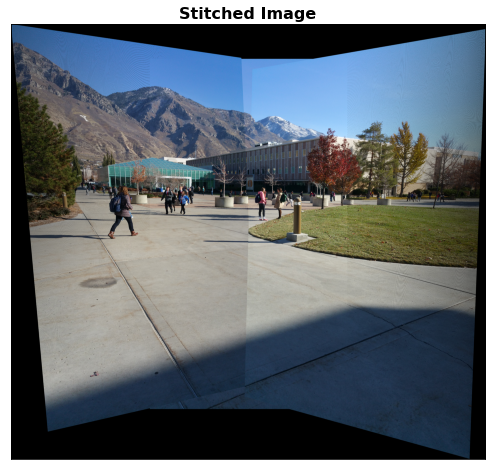

In [13]:
stitch_images(images, homographies, base_img_idx=base_img_idx)

### Final Results and Improvements

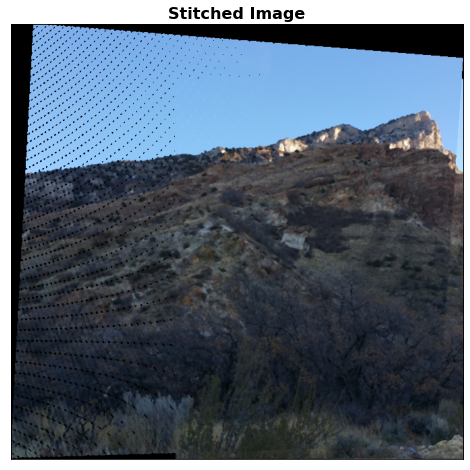

In [14]:
# Output results for additional images here
# Feel free to add as many cells as you wish
img1 = cv2.imread('./Images/squaw_peak1_sq600.png')
img2 = cv2.imread('./Images/squaw_peak2_sq600.png')

images = [img1, img2]

keypoints, descriptors, example_images = find_kp_and_des(images, True)

matches, example_matches = find_matches(images, descriptors, keypoints, True)

base_img_idx = 1

homographies = ransac_homographies(keypoints, matches, base_img_idx=base_img_idx)

stitch_images(images, homographies, base_img_idx=base_img_idx)

### Grading

To get 100% you need to (i) implement RANSAC and additionally (ii) either implement the feature matching yourself (instead of using built-in matching functions such as `cv2.BFMatcher()`), or incorporate one of the following improvements:
* A nice clean compositing/blending approach so that edges/artifacts are not noticeable.
* Automatic selection of which image should be the base
* Handling more than 3 photos
* Another enhancement approved by Dr. Farrell

Points for this assigment will be assigned as follows (100 points total):
* [10 pts] Extracting features from both images (interest points and descriptors).
* [20 pts] Four-point algorithm to estimate homographies.
* [30 pts] RANSAC implemented (partial points given for poor alignments).
* [20 pts] Images warped appropriately (aligning on top of each other).
* [10 pts] Clean final image (extents of merged image should fit the enscribed rectangle).
* [10 pts] Implementing matching or other improvement (see above). Bonus points may be given for additional enhancements.

## Write-up:
Provide an explanation for the following items:
* In what scenarios was it difficult to get good alignments between images?
* If you have any suggestions for how to improve this project in the future, list them here.

* <span style="color:red;">In what scenarios was it difficult to get good alignments between images?</span>
Smaller images were harder to get good alignments; I think this might be because there is less data in the images.  If you look at the squaw peak images I used, the alignment is not quite as good and there are several black dots on the left side of the stitched image.
* <span style="color:red;">If you have any suggestions for how to improve this project in the future, list them here.</span>
This lab took forever, and I didn't spend much time on trying to make improvements/speed things up because I spent a lot of time on just trying to get basic things to work and had to move on to work for other classes/projects.  If you could somehow reduce the time required for this lab that would be great.  Maybe give code snippets/examples of what needs to be done or give more project hints.
* <span style="color:red;">Improvement I made for full credit</span> I created all the functions needed for the image stitching so that it will work with an arbitrary amount of photos (3, more than 3, 2, etc.).  The only thing required from the user is a list of images and the index of the base image (index where the base image is in the list of images).